In [11]:
import pandas as pd
import datetime as dt
from pandas_profiling import ProfileReport
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
orderbook = pd.read_csv('df_order_book_20200817.csv')
(orderbook.isnull().sum()/len(orderbook)) * 100
orderbook.loc[:,'BidQuoteQty']= orderbook.loc[:,'bidPrice'] * orderbook.loc[:,'bidQty']
orderbook.loc[:,'AskQuoteQty'] = orderbook.loc[:,'askPrice'] * orderbook.loc[:,'askQty']
orderbook_100=orderbook.drop(orderbook[orderbook['depth']>99].index)
orderbook_100=orderbook_100.reset_index(drop=True)

orderbook
orderbook_100
orderbook_1


In [5]:
# build corresbonding 

class Node:   
  def __init__(self): 
    # price, quantity and quoteQty
    self.bid = np.zeros((100, 3), dtype=float)
    self.ask = np.zeros((100, 3), dtype=float)
    self.spread=0
    self.mid=0
    # weighted average price 
    self.wap=0

    

orderbook_list=[]
timestamps=set()
idx=0
while idx<len(orderbook_100):
  a=Node()
  for i in range(100):
    if idx>=len(orderbook_100):
      break
    
    a.bid[i][0]=orderbook_100['bidPrice'][idx]
    a.bid[i][1]=orderbook_100['bidQty'][idx]
    a.bid[i][2]=orderbook_100['BidQuoteQty'][idx]
    a.ask[i][0]=orderbook_100['askPrice'][idx]
    a.ask[i][1]=orderbook_100['askQty'][idx]
    a.ask[i][2]=orderbook_100['AskQuoteQty'][idx]
    if i==0:
      a.mid=(a.bid[0][0]+a.ask[0][0])/2
      a.spread=(a.ask[0][0]/a.bid[0][0])-1
      a.wap=(a.bid[0][0]*a.ask[0][1]+a.bid[0][1]*a.ask[0][0])/(a.ask[0][1]+a.bid[0][1])

    idx=idx+1
  
  orderbook_list.append(a)

      

In [16]:
bidPrice=[]
bidQty=[]
askPrice=[]
askQty=[]
midPrice=[]
wap=[]
spread=[]
for node in orderbook_list:
  bidPrice.append(node.bid[0][0])
  bidQty.append(node.bid[0][1])
  askPrice.append(node.ask[0][0])
  askQty.append(node.ask[0][1])
  midPrice.append(node.mid)
  wap.append(node.wap)
  spread.append(node.spread)

orderbook_1 = pd.DataFrame(list(zip( bidPrice, bidQty,askPrice,askQty, midPrice,wap, spread)),
               columns =['bidPrice', 'bidQty','askPrice','askQty', 'midPrice','wap', 'spread'])
orderbook_1['Log returns'] = np.log(orderbook_1['midPrice']/orderbook_1['midPrice'].shift())
orderbook_1['Log returns'].std()
orderbook_1

,bidPrice,bidQty,askPrice,askQty,midPrice,wap,spread,Log returns
0,12329.07,0.001113,12329.27,1.600000,12329.170,12329.070139,1.622182e-05,NaN
1,12329.79,0.001151,12329.80,0.010410,12329.795,12329.790996,8.110438e-07,0.000051
2,12329.53,1.876932,12329.54,0.136318,12329.535,12329.539323,8.110609e-07,-0.000021
3,12329.53,2.650926,12329.54,0.016285,12329.535,12329.539939,8.110609e-07,0.000000
4,12330.38,0.431779,12330.39,0.010367,12330.385,12330.389766,8.110050e-07,0.000069
...,...,...,...,...,...,...,...,...
2754,12354.27,0.171223,12354.28,3.418578,12354.275,12354.270477,8.094367e-07,0.000000
2755,12354.27,3.063886,12354.28,3.317418,12354.275,12354.274801,8.094367e-07,0.000000
2756,12354.27,6.014475,12354.28,0.400000,12354.275,12354.279376,8.094367e-07,0.000000
2757,12354.28,3.529510,12354.58,0.034787,12354.430,12354.577072,2.428308e-05,0.000013


## pending order


## plot 

Text(0, 0.5, 'Quoto')

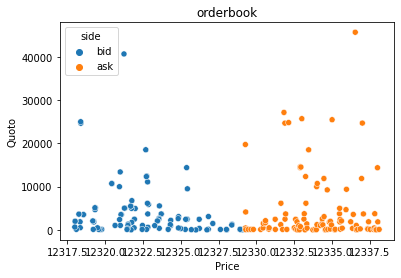

In [ ]:
bid=pd.DataFrame(orderbook_list[0].bid, columns =['price', 'quantity', 'quote'], dtype = float) 
bid['side']='bid'
ask=pd.DataFrame(orderbook_list[0].ask, columns =['price', 'quantity', 'quote'], dtype = float) 
ask['side']='ask'
frames=[bid,ask]
result=pd.concat(frames)

fig, ax = plt.subplots()
ax.set_title(f"orderbook")

sns.scatterplot(x="price", y="quote", hue="side", data=result, ax=ax)

ax.set_xlabel("Price")
ax.set_ylabel("Quoto")


##Extract Signal

In [17]:
def RSI(t, periods=100):
    length = len(t)
    rsies = [np.nan]*length
    
    if length <= periods:
        return rsies
  
    up_avg = 0
    down_avg = 0

    #首先计算第一个RSI，用前periods+1个数据，构成periods个价差序列;
    first_t = t[:periods+1]
    for i in range(1, len(first_t)):
        #价格上涨;
        if first_t[i] >= first_t[i-1]:
            up_avg += first_t[i] - first_t[i-1]
        #价格下跌;
        else:
            down_avg += first_t[i-1] - first_t[i]
    up_avg = up_avg / periods
    down_avg = down_avg / periods
    rs = up_avg / down_avg
    rsies[periods] = 100 - 100/(1+rs)


    for j in range(periods+1, length):
        up = 0
        down = 0
        if t[j] >= t[j-1]:
            up = t[j] - t[j-1]
            down = 0
        else:
            up = 0
            down = t[j-1] - t[j]
        #类似移动平均的计算公式;
        up_avg = (up_avg*(periods - 1) + up)/periods
        down_avg = (down_avg*(periods - 1) + down)/periods
        rs = up_avg/down_avg
        rsies[j] = 100 - 100/(1+rs)
    return rsies  
   

In [13]:
#通过波动率决定摆盘总金额

def past_realized_volatility(time, N):
  sum=0
  for i in range(1,1000):
      sum+=pow((log(orderbook_1['wap'][time-i])-log(orderbook_1['wap'][time-1-i])),2)
  
  return sum/N




In [ ]:
#判读买盘还是卖盘
def past_realized_volatility(time, N):
  sum=0
  for i in range(1,1000):
      sum+=pow((log(orderbook_1['wap'][time-i])-log(orderbook_1['wap'][time-1-i])),2)
  
  return sum/N

In [ ]:
# 判断自身资金平衡性


## shape of pending order

In [ ]:
def pending(levels, spread, cash_amount, coin_amount, t, midPrice, orderbook):
  # 如果波动率大 减小前半部分挂单或者挂单金额总量
  # 离中间价越远 挂单量越多
  # 
  
  
  pending_bidP=[]
  pending_bidQ=[]
  pending_askP=[]
  pending_askQ=[]


 # 初始状态 使用线性函数或者反函数，根据不同参数进行修改

 # 初始化
  count=0
  # 积分
  for i in range(1,levels):
    count+=i 
  per_ask= coin_amount/count
  per_bid= cash_amount/count

  for i in range(1,levels):
    pending_bidP.append(midPrice(1-i*spread))
    pending_askP.append(midPrice(1+i*spread))
    pending_bidQ.append(per_bid*i)
    pending_askQ.append(per_ask*i)
  

#波动率过大

#超买

#超卖


  return list(zip( pending_bidP,pending_bidQ,pending_askP,pending_askQ))

In [ ]:
# 测试与画图
pend=pending(20,0.01,10000, 1, 1000, midPrice, orderbook_1):

bid=pd.DataFrame(orderbook_list[0].bid, columns =['price', 'quantity', 'quote'], dtype = float) 
bid['side']='bid'
ask=pd.DataFrame(orderbook_list[0].ask, columns =['price', 'quantity', 'quote'], dtype = float) 
ask['side']='ask'
frames=[bid,ask]
result=pd.concat(frames)

fig, ax = plt.subplots()
ax.set_title(f"orderbook")

sns.scatterplot(x="price", y="quote", hue="side", data=result, ax=ax)

ax.set_xlabel("Price")
ax.set_ylabel("Quoto")